# Joe's cool code

In [36]:
# Import General Libs
import pandas as pd
import os
import scipy as sp
import scipy.signal as sps
from scipy import integrate
from scipy import diff
import numpy as np
import matplotlib.pyplot as plt
import random

import hvplot.pandas  # noqa

import matplotlib.dates as mdates

# Import project libs
import Data.DataWrangle as DW

In [37]:
#Data setup, all major data frames used are here
cleanData = DW.read_into_MC_format(with_pct_change=True)

Peak_data = pd.concat([
    DW.tag_columns(cleanData['VIX'],'VIX'), 
    DW.tag_columns(cleanData['SPY'],'SPY').shift(-1)]
    ,join='inner',axis=1).dropna()

covid_data = Peak_data.loc['2020-01-20':] # Official starting day of covid in the US

## Intergration Work

In [38]:
# def add_Rolling_ID_Values(df:pd.DataFrame,data_col,rollNum):
#     result = add_rolling_integrate(df,data_col,rollNum)
#     result = add_rolling_derivatives(result,data_col,rollNum)
#     return result
def add_rolling_integrate(df:pd.DataFrame,data_col,rollNum):
    data = df[data_col]
    integral = data.rolling(rollNum).apply(integrate.trapz)
    integral = integral.rename(f'{data_col}_integral')
    return pd.concat([df,integral],axis=1)

# def add_rolling_derivatives(df:pd.DataFrame,data_col,rollNum):
#     data = df[data_col]
#     derivative = data.rolling(rollNum).apply(diff)
#     derivative = derivative.rename(f'{data_col}_derivative')
#     return pd.concat([df,derivative],axis=1)

In [39]:
window = 2
VIX_PID_Data = add_rolling_integrate(cleanData['VIX'],'close',window)
VIX_PID_Data = add_rolling_integrate(VIX_PID_Data,'pct_change',window)
VIX_PID_Data = DW.tag_columns(VIX_PID_Data,'VIX')
# VIX_PID_Data.dropna()

In [40]:
SPY_PID_Data = add_rolling_integrate(cleanData['SPY'],'close',window)
SPY_PID_Data = add_rolling_integrate(SPY_PID_Data,'pct_change',window)
SPY_PID_Data = DW.tag_columns(SPY_PID_Data,'SPY')
# SPY_PID_Data

In [41]:
graphing_data = pd.concat([VIX_PID_Data,SPY_PID_Data],axis=1)
graphing_data


,VIX_close,VIX_pct_change,VIX_close_integral,VIX_pct_change_integral,SPY_close,SPY_pct_change,SPY_close_integral,SPY_pct_change_integral
timestamp,,,,,,,,
1990-01-02,17.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,18.19,0.055104,17.715,NaN,NaN,NaN,NaN,NaN
1990-01-04,19.22,0.056625,18.705,0.055864,NaN,NaN,NaN,NaN
1990-01-05,20.11,0.046306,19.665,0.051465,NaN,NaN,NaN,NaN
1990-01-08,20.26,0.007459,20.185,0.026882,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-03-24,21.67,-0.080611,22.620,-0.026574,450.48,0.015052,447.140,0.001087
2022-03-25,20.81,-0.039686,21.240,-0.060149,452.69,0.004906,451.585,0.009979
2022-03-28,19.63,-0.056704,20.220,-0.048195,455.91,0.007113,454.300,0.006009


<AxesSubplot:xlabel='timestamp'>

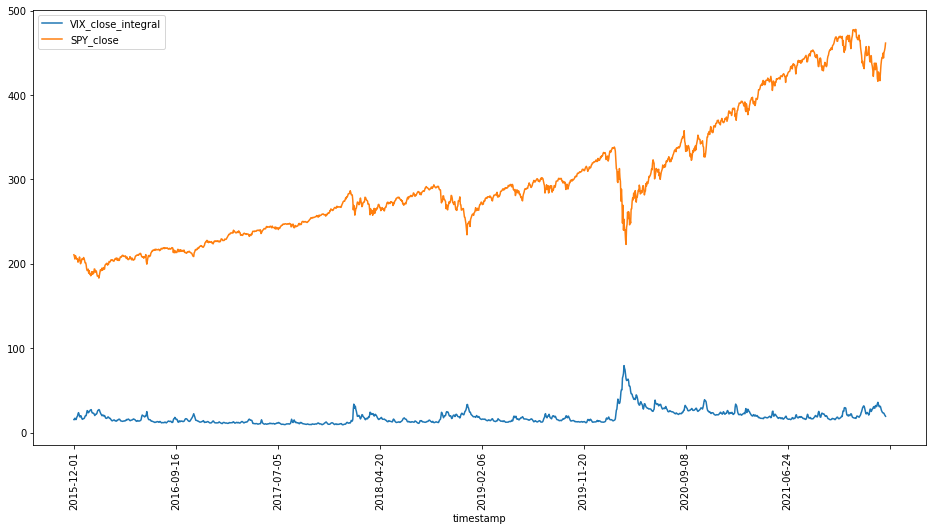

In [42]:
scaled = graphing_data
# scaled['VIX_close_integral'] = graphing_data['VIX_close_integral']+graphing_data['SPY_close'].dropna().iloc[0]
scaled[['VIX_close_integral','SPY_close']].dropna().plot(rot=90,figsize=(16,8))

<AxesSubplot:xlabel='timestamp'>

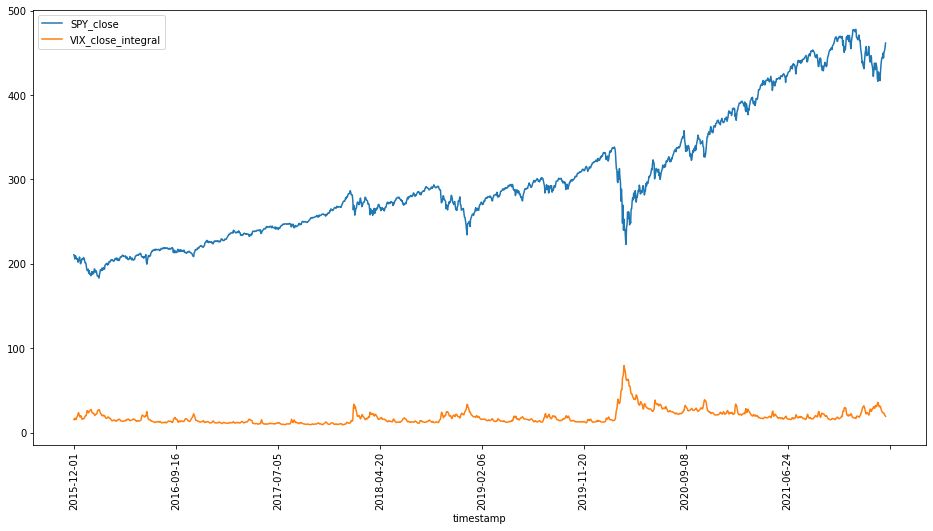

In [43]:
scaled = graphing_data
# scaled['VIX_close_integral'] = graphing_data['VIX_close_integral']+graphing_data['SPY_close'].dropna().iloc[0]
scaled[['SPY_close','VIX_close_integral']].dropna().plot(rot=90,figsize=(16,8))

## SPY and VIX Peak analysis

In [44]:
Peak_data

,VIX_close,VIX_pct_change,SPY_close,SPY_pct_change
timestamp,,,,
2015-12-01,14.67,-0.090515,208.54,-0.010158
2015-12-02,15.91,0.084526,205.58,-0.014194
2015-12-03,18.11,0.138278,209.66,0.019846
2015-12-04,14.81,-0.182220,208.27,-0.006630
2015-12-07,15.84,0.069548,206.99,-0.006146
...,...,...,...,...
2022-03-23,23.57,0.027463,450.48,0.015052
2022-03-24,21.67,-0.080611,452.69,0.004906
2022-03-25,20.81,-0.039686,455.91,0.007113


In [90]:
Simulated_Q3=16.76
Simulated_95_up = 34
def peaks_std(df:pd.DataFrame, stds,roll,meanfactor=1,MinLine=None):
    rollMean = df.rolling(window=roll).mean()
    rollSTD = df.rolling(window=roll).std()
    thresh_df = (rollMean*meanfactor+rollSTD*stds)

    if MinLine != None :
        thresh_df.loc[thresh_df<MinLine] = MinLine
        thresh_df
        
    thresh = thresh_df.to_list()
    thresh[:roll]=[100]*roll

    np_thresh = np.array(thresh)
    
    peakArray = sps.find_peaks(df,height=np_thresh)
    return df[peakArray[0]]

peaks = peaks_std(Peak_data['VIX_close'],stds=1.5,roll=60)
peak_noiseless  = peaks_std(Peak_data['VIX_close'],stds=1.5,roll=30, MinLine=Simulated_Q3)
# Peak_data.loc[peaks.index]

In [94]:
def plot_with_marks(data,markdata,stockname='SPY',on_data_line=True,Peak_name='VIX Peaks'):
    if stockname=='VIX' :
        plt.plot(data.index,data.to_list(),'k-',label=stockname)
    else:
        plt.plot(data.index,data.to_list(),label=stockname)
    if Peak_name=='VIX Peaks':
        if on_data_line : plt.plot(markdata.index,data.loc[markdata.index],"r^",label=Peak_name)
        else : plt.plot(markdata.index,markdata.tolist(),"r^",label=Peak_name)
    else:
        if on_data_line : plt.plot(markdata.index,data.loc[markdata.index],"x",label=Peak_name)
        else : plt.plot(markdata.index,markdata.tolist(),"x",label=Peak_name)
    axis = plt.gca()
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=100))

    fig = plt.gcf()
    fig.autofmt_xdate()
    fig.set_size_inches(12,8)
    #Axis labels
    plt.xlabel('Date')
    plt.ylabel('Closing')
    #Legend
    plt.legend()
    #style

    return plt.show()

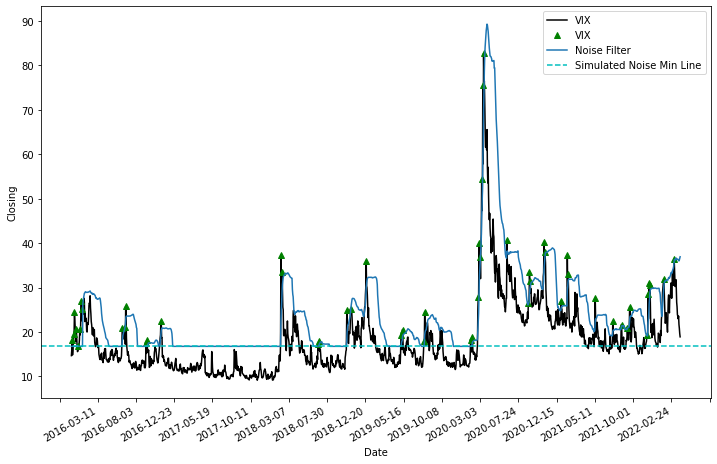

In [47]:
df = Peak_data['VIX_close']
MinLine = Simulated_Q3
rollMean = df.rolling(window=30).mean()
rollSTD = df.rolling(window=30).std()
thresh_df = (rollMean+rollSTD*2)

if MinLine != None :
    thresh_df.loc[thresh_df<MinLine] = MinLine
    thresh_df
    
thresh = thresh_df.to_list()
thresh[:30]=[MinLine]*30

np_thresh = np.array(thresh)

peakArray = sps.find_peaks(df,height=np_thresh)
markdata = df[peakArray[0]]
data = df
stockname = 'VIX'
Peak_name = 'VIX'

plt.plot(data.index,data.to_list(),'k-',label=stockname)
plt.plot(markdata.index,data.loc[markdata.index],"g^",label=Peak_name)
plt.plot(np_thresh,'-',label='Noise Filter')
plt.axhline(y=MinLine,color='c',linestyle ='--',label='Simulated Noise Min Line')

axis = plt.gca()
axis.xaxis.set_major_locator(mdates.DayLocator(interval=100))

fig = plt.gcf()
fig.autofmt_xdate()
fig.set_size_inches(12,8)
#Axis labels
plt.xlabel('Date')
plt.ylabel('Closing')
#Legend
plt.legend()

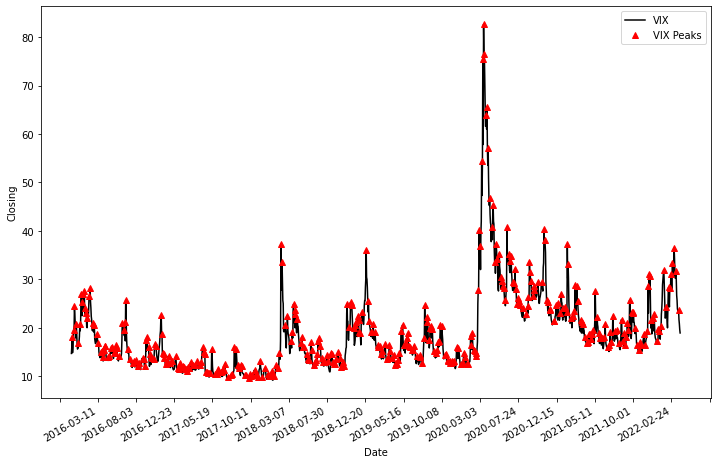

In [95]:
all_peaks = peaks_std(Peak_data['VIX_close'],stds=0,roll=2,meanfactor=0)
plot_with_marks(Peak_data['VIX_close'],all_peaks,'VIX')

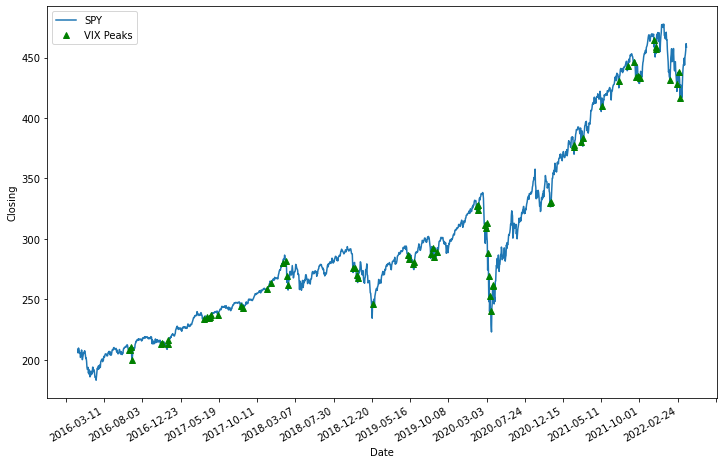

In [48]:
plot_with_marks(Peak_data['SPY_close'],peaks,'SPY')

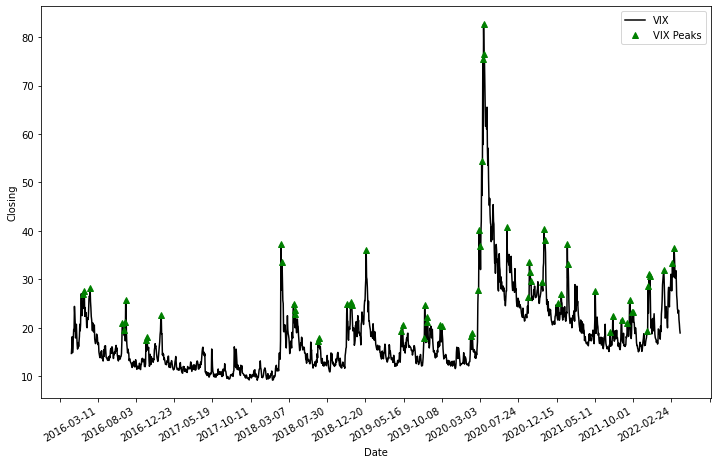

In [49]:
plot_with_marks(Peak_data['VIX_close'],peak_noiseless,'VIX')

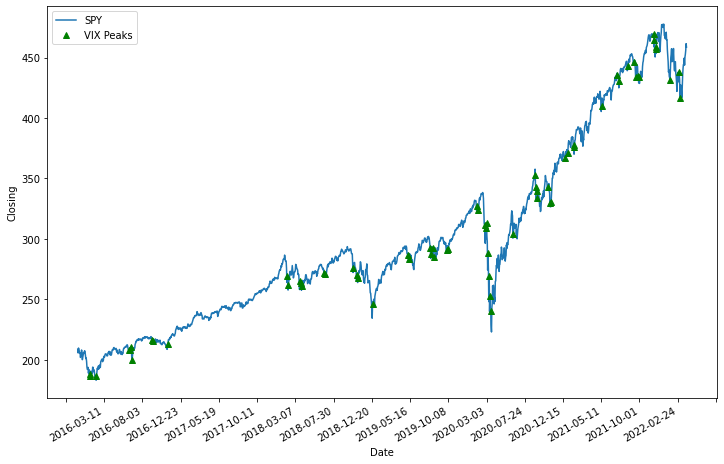

In [50]:
plot_with_marks(Peak_data['SPY_close'],peak_noiseless,'SPY')

In [113]:
noiseless_df = pd.DataFrame(peak_noiseless)
noiseless_df = noiseless_df.reset_index()
noiseless_df['next timestamp'] = noiseless_df['timestamp'].shift(-1)
noiseless_df[['next timestamp','timestamp']] = noiseless_df[['next timestamp','timestamp']].apply(pd.to_datetime)
noiseless_df['peak delta'] = noiseless_df['next timestamp']-noiseless_df['timestamp']

noiseless_df

,timestamp,VIX_close,next timestamp,peak delta
0,2016-01-15,27.02,2016-01-20,5 days
1,2016-01-20,27.59,2016-02-11,22 days
2,2016-02-11,28.14,2016-06-13,123 days
3,2016-06-13,20.97,2016-06-17,4 days
4,2016-06-17,19.41,2016-06-22,5 days
...,...,...,...,...
60,2021-12-01,31.12,2021-12-03,2 days
61,2021-12-03,30.67,2022-01-26,54 days
62,2022-01-26,31.96,2022-03-01,34 days
63,2022-03-01,33.32,2022-03-07,6 days


## Earnings analysis

In [51]:
def earnings(init_investment,current_spy,investments):
    results = []
    shares = []
    num_invests = len(investments)
    chunk = init_investment/num_invests
    print(f'${chunk:.2f} investments over {num_invests} trades')
    for invest_day in investments['SPY_close'].to_list():
        share = (chunk/invest_day)
        shares.append(share)
        results.append(
            ((current_spy-invest_day)/invest_day) * share
            )
    return f'Invest: ${init_investment:.2f}, Result: ${sum(shares)*current_spy:.2f} Gain: ${sum(shares)*current_spy - init_investment:.2f}'
def gains(init_investment,current_spy,investments):
    results = []
    shares = []
    num_invests = len(investments)
    chunk = init_investment/num_invests
    # print(f'${chunk:.2f} investments over {num_invests} trades')
    for invest_day in investments['SPY_close'].to_list():
        share = (chunk/invest_day)
        shares.append(share)
        results.append(
            ((current_spy-invest_day)/invest_day) * share
            )
    return (sum(shares)*current_spy - init_investment)

earnings(init_investment = 100000,current_spy = Peak_data['SPY_close'].tail(1)[0],investments=Peak_data.loc[peak_noiseless.index])

$1538.46 investments over 65 trades


'Invest: $100000.00, Result: $154115.07 Gain: $54115.07'

In [52]:
def linear_investment_times(data,compare):
    num=len(data.loc[compare.index])+1
    pull_num = int(len(data)/num)
    pulls = []
    for i in range(num):
        pulls.append(pull_num*i)
    return data.iloc[pulls].tail(num-1)
linear_invest = linear_investment_times(Peak_data,peak_noiseless)

In [53]:
earnings(init_investment = 100000,current_spy = Peak_data['SPY_close'].tail(1)[0],investments=linear_invest)

$1538.46 investments over 65 trades


'Invest: $100000.00, Result: $163380.15 Gain: $63380.15'

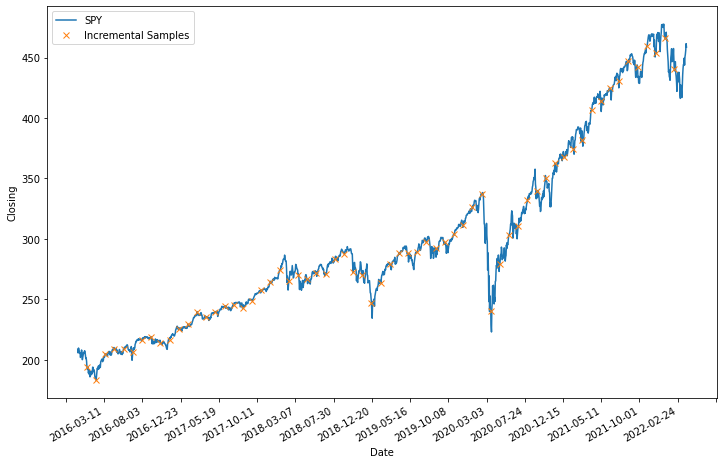

In [54]:
plot_with_marks(Peak_data['SPY_close'],linear_invest,'SPY',Peak_name='Incremental Samples')

### Post Covid Analysis

$2325.58 investments over 43 trades
Invest: $100000.00, Result: $121929.24 Gain: $21929.24


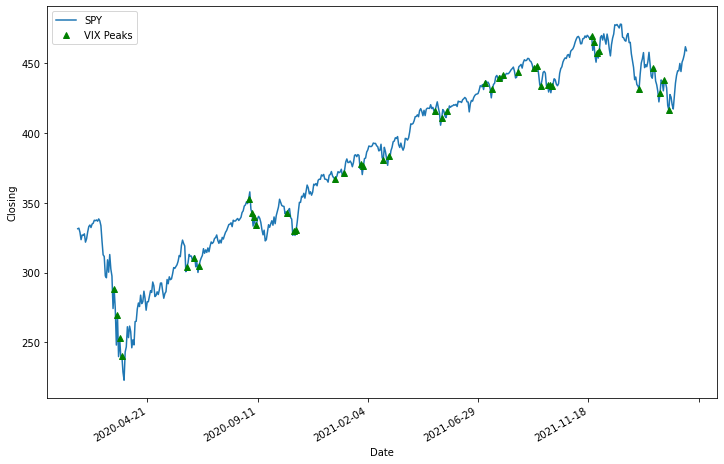

In [55]:
covid_data = Peak_data.loc['2020-01-20':]
peak_covid  = peaks_std(covid_data['VIX_close'],stds=1,roll=30, MinLine=Simulated_Q3)
print(
    earnings(init_investment = 100000,current_spy = covid_data['SPY_close'].tail(1)[0],investments=covid_data.loc[peak_covid.index])
)
plot_with_marks(covid_data['SPY_close'],peak_covid,'SPY')

$2325.58 investments over 43 trades
Invest: $100000.00, Result: $123732.12 Gain: $23732.12


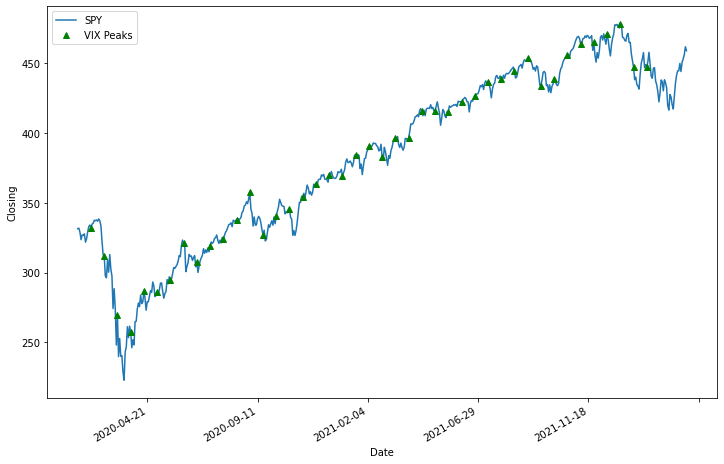

In [56]:
linear_invest = linear_investment_times(covid_data,peak_covid)
print(
    earnings(init_investment = 100000,current_spy = covid_data['SPY_close'].tail(1)[0],investments=linear_invest)
)
plot_with_marks(covid_data['SPY_close'],linear_invest)

## N-th element compare

In [57]:
peak_covid  = peaks_std(covid_data['VIX_close'],stds=1,roll=30, MinLine=Simulated_Q3)
random_sample = random.randint(0,len(peak_covid))
current_spy = covid_data['SPY_close'].tail(1)[0]

In [58]:
covid_VIX_investments = covid_data.loc[peak_covid.index]
gain_table = {'Index':[],'High Vol':[],'Interval':[]
,'Time difference':[]
}
for i in range(len(peak_covid)):
    gain_table['Index'].append(i)
    gain_table['High Vol'].append(gains(100000,current_spy, covid_VIX_investments.iloc[i:i+1]))
    gain_table['Interval'].append(gains(100000,current_spy, linear_invest.iloc[i:i+1]))
    gain_table['Time difference'].append(pd.to_datetime(covid_VIX_investments.iloc[i:i+1].index[0])-pd.to_datetime(linear_invest.iloc[i:i+1].index[0]))
tbl_df=pd.DataFrame(gain_table)
number_better = tbl_df[tbl_df['High Vol']>=tbl_df['Interval']].describe()['Index']['count']
print(f'Out of {len(peak_covid)} tests picking a High Volitility moment has better gains than a different point in time {number_better:.0f} times')
# tbl_df

Out of 43 tests picking a High Volitility moment has better gains than a different point in time 15 times


## Spread away from the peak analysis

In [59]:
covid_VIX_investments = covid_data.loc[peak_covid.index]
suuuper = 5 # Change this to get different spread
investment = current_spy # Currently set to just buy 1-ish stock (it doesn't really matter)
gain_table = {'Index':[],'High Vol':[],
f'{1*suuuper} Day Before':[],f'{2*suuuper} Day Before':[],f'{3*suuuper} Day Before':[],f'{4*suuuper} Day Before':[],f'{5*suuuper} Day Before':[],
f'{1*suuuper} Day After':[],f'{2*suuuper} Day After':[],f'{3*suuuper} Day After':[],f'{4*suuuper} Day After':[],f'{5*suuuper} Day After':[],
}
day_delta = pd.DateOffset(days=1)
for i in range(len(peak_covid)):
    gain_table['Index'].append(i)
    gain_table['High Vol'].append(gains(investment,current_spy, covid_VIX_investments.iloc[i:i+1]))
    date = pd.to_datetime(covid_VIX_investments.iloc[i:i+1].index[0])
    for j in range(1,6):
        date_delta = pd.DateOffset(days=j)
        date_super_delta = pd.DateOffset(days=suuuper*j)
        plus_df = covid_data.loc[(date+date_super_delta).strftime('%Y-%m-%d'):(date+date_delta+date_super_delta).strftime('%Y-%m-%d')].head(1)
        if plus_df.empty :
            gain_table[f'{j*suuuper} Day After'].append(0)
        else:
            gain_table[f'{j*suuuper} Day After'].append(gains(investment,current_spy,plus_df))
        minus_df = covid_data.loc[(date-date_super_delta-day_delta).strftime('%Y-%m-%d'):(date+date_super_delta).strftime('%Y-%m-%d')].head(1)
        if plus_df.empty :
            gain_table[f'{j*suuuper} Day Before'].append(0)
        else:
            gain_table[f'{j*suuuper} Day Before'].append(gains(investment,current_spy,minus_df))

tbl_df=pd.DataFrame(gain_table).set_index('Index')
# number_better = tbl_df[tbl_df['High Vol']>=tbl_df['Interval']].describe()['Index']['count']
# print(f'Out of {len(peak_covid)} tests picking a High Volitility moment has better gains than a different point in time {number_better:.0f} times')
pd.DataFrame(tbl_df.idxmax(axis=1)).value_counts()

High Vol         10
25 Day Before     9
10 Day After      5
5 Day After       5
20 Day After      4
15 Day After      3
20 Day Before     3
10 Day Before     1
15 Day Before     1
25 Day After      1
5 Day Before      1
dtype: int64

In [60]:
pd.DataFrame(tbl_df['High Vol']-tbl_df.max(axis=1)).describe()

,0
count,43.000000
mean,-17.326342
std,31.952709
min,-190.093847
25%,-21.500120
50%,-7.379724
75%,-0.351997
max,0.000000


In [61]:
def add_data(diction:dict,data,location):
    if location in diction :
        diction[location].append(data)
    else :
        diction[location]=[data]

In [62]:
# To take this further I should ensure the date shifted is not already present in the peak occurances. This will better represent Peak investment worth
def spreadAnalysis(numberDaysTotal,stepNum,data_range,peak_occurances):
    VIX_investments = data_range.loc[peak_occurances.index]
    investment = current_spy # Currently set to just buy 1-ish stock (it doesn't really matter)
    gain_table = {'Index':[],'High Vol':[]}
    day_delta = pd.DateOffset(days=1)
    for i in range(len(peak_occurances)):
        gain_table['Index'].append(i)
        gain_table['High Vol'].append(gains(investment,current_spy, VIX_investments.iloc[i:i+1]))
        date = pd.to_datetime(VIX_investments.iloc[i:i+1].index[0])

        day_delta = pd.DateOffset(days=1)
        for j in range(1,numberDaysTotal+1,stepNum):
            date_delta = pd.DateOffset(days=j)

            # perform_plus = True
            perform_minus = True
            # plus_shift=(date+date_delta).strftime('%Y-%m-%d')
            minus_shift=(date-date_delta-day_delta).strftime('%Y-%m-%d')
            minus_shift1=(date-date_delta-pd.DateOffset(days=2)).strftime('%Y-%m-%d')
            minus_shift2=(date-date_delta-pd.DateOffset(days=3)).strftime('%Y-%m-%d')
            minus_shift3=(date-date_delta-pd.DateOffset(days=4)).strftime('%Y-%m-%d')
            minus_shift4=(date-date_delta-pd.DateOffset(days=5)).strftime('%Y-%m-%d')
            minus_shift5=(date-date_delta-pd.DateOffset(days=6)).strftime('%Y-%m-%d')
            # if plus_shift in peak_occurances.index.tolist() : perform_plus = False
            if minus_shift in peak_occurances.index.tolist() : perform_minus = False
            if minus_shift1 in peak_occurances.index.tolist() : perform_minus = False
            if minus_shift2 in peak_occurances.index.tolist() : perform_minus = False
            if minus_shift3 in peak_occurances.index.tolist() : perform_minus = False
            if minus_shift4 in peak_occurances.index.tolist() : perform_minus = False
            if minus_shift5 in peak_occurances.index.tolist() : perform_minus = False

            # plus_df = data_range.loc[(date+date_delta).strftime('%Y-%m-%d'):(date+date_delta+day_delta).strftime('%Y-%m-%d')].head(1)
            # if plus_df.empty or not perform_plus:
            #     add_data(gain_table,0,
            #     f'{j*stepNum} Day After')
            # else:
            #     add_data(gain_table,gains(investment,current_spy,plus_df),
            #     f'{j*stepNum} Day After')
            minus_df = data_range.loc[(date-date_delta-day_delta).strftime('%Y-%m-%d'):(date+date_delta).strftime('%Y-%m-%d')].head(1)
            if minus_df.empty or not perform_minus:
                add_data(gain_table,0,
                f'{j*stepNum} Day Before')
            else:
                add_data(gain_table,gains(investment,current_spy,minus_df),
                f'{j*stepNum} Day Before')

    tbl_df=pd.DataFrame(gain_table).set_index('Index')
    # return tbl_df # For some reason I cannot use this and the value_it function...it breaks no idea why returning it breaks it
    return pd.DataFrame(tbl_df.idxmax(axis=1)).value_counts()

In [63]:
def value_it(valueFrame): #For some reason I cannot use this 
    return pd.DataFrame(valueFrame.idxmax(axis=1)).value_counts()


In [69]:
All_Analysis = pd.read_csv('./Data/Processed_Clean_Data/Gains_Year_Data.csv')

numberDaysTotal = 365
stepNum = 1 # Steps
# All_Analysis = pd.DataFrame(spreadAnalysis(numberDaysTotal, stepNum,Peak_data,peak_noiseless)).rename(columns={0:numberDaysTotal})
# for day in range(numberDaysTotal-1,1,-1*stepNum):
#     df = pd.DataFrame(spreadAnalysis(day, stepNum,Peak_data,peak_noiseless)).rename(columns={0:day})
#     # df = pd.DataFrame(value_it(spreadAnalysis(day, stepNum,Peak_data,peak_noiseless))).rename(columns={0:day})
#     All_Analysis = pd.concat([All_Analysis,df],axis=1,join='outer')

In [70]:
# All_Analysis.to_csv('./Data/Processed_Clean_Data/Gains_Year_Data1.csv')
All_Analysis.drop(columns=['Unnamed: 0'],inplace=True)

In [74]:
All_Analysis.set_index('Unnamed: 0.1.1',inplace=True)
All_Analysis.dropna(how='all')

,365,364,363,362,361,360,359,358,357,356,...,11,10,9,8,7,6,5,4,3,2
Unnamed: 0.1.1,,,,,,,,,,,,,,,,,,,,,
1 Day Before,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,8.0,8.0,8.0,8.0,9.0,9.0,10.0,14.0,15.0,16.0
10 Day Before,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100 Day Before,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Day Before,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102 Day Before,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96 Day Before,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97 Day Before,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98 Day Before,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
All_Analysis[f'{5}']
# All_Analysis[5]

Unnamed: 0.1.1
1 Day Before      10.0
10 Day Before      NaN
100 Day Before     NaN
101 Day Before     NaN
102 Day Before     NaN
                  ... 
96 Day Before      NaN
97 Day Before      NaN
98 Day Before      NaN
99 Day Before      NaN
High Vol          25.0
Name: 5, Length: 358, dtype: float64

In [76]:
Scatter_data = {}
for day in range(5,numberDaysTotal):
    sumBucket = All_Analysis[f'{day}'].loc[['High Vol','1 Day Before','2 Day Before','3 Day Before','4 Day Before','5 Day Before']].sum()
    # Sum of all winning days NOT the high volatility day
    Scatter_data[day] = (sumBucket/65)*100
    # print(high_vol_number)
    # filtered = All_Analysis[day][All_Analysis[day]>high_vol_number]
    # print(filtered)
    # Scatter_data[day] = (1-(filtered.sum()/65))*100

In [77]:
Scatter_data

{5: 100.0,
 6: 93.84615384615384,
 7: 90.76923076923077,
 8: 89.23076923076924,
 9: 87.6923076923077,
 10: 84.61538461538461,
 11: 83.07692307692308,
 12: 80.0,
 13: 76.92307692307693,
 14: 75.38461538461539,
 15: 72.3076923076923,
 16: 72.3076923076923,
 17: 72.3076923076923,
 18: 72.3076923076923,
 19: 72.3076923076923,
 20: 69.23076923076923,
 21: 69.23076923076923,
 22: 69.23076923076923,
 23: 67.6923076923077,
 24: 67.6923076923077,
 25: 66.15384615384615,
 26: 64.61538461538461,
 27: 63.07692307692307,
 28: 61.53846153846154,
 29: 60.0,
 30: 58.46153846153847,
 31: 58.46153846153847,
 32: 55.38461538461539,
 33: 53.84615384615385,
 34: 52.307692307692314,
 35: 46.15384615384615,
 36: 44.61538461538462,
 37: 43.07692307692308,
 38: 43.07692307692308,
 39: 43.07692307692308,
 40: 43.07692307692308,
 41: 43.07692307692308,
 42: 43.07692307692308,
 43: 41.53846153846154,
 44: 41.53846153846154,
 45: 41.53846153846154,
 46: 40.0,
 47: 40.0,
 48: 36.92307692307693,
 49: 36.923076923076

No handles with labels found to put in legend.


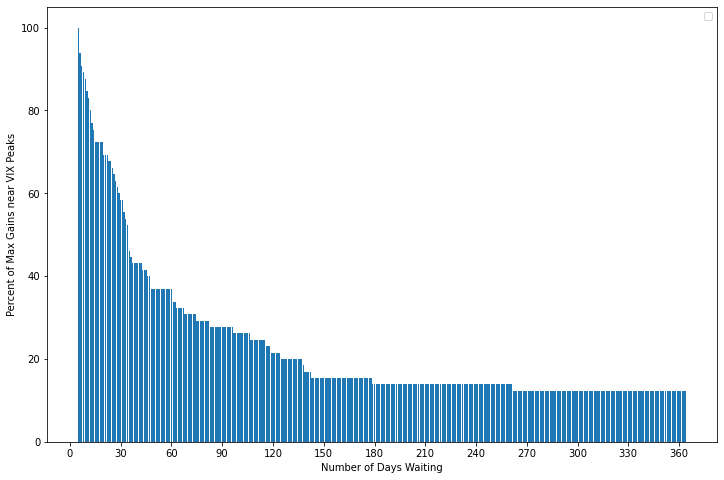

In [78]:
plt.bar(x=Scatter_data.keys(),height=Scatter_data.values())
axis = plt.gca()
# axis.xaxis.set_major_locator(5)

fig = plt.gcf()
fig.set_size_inches(12,8)
#Axis labels
plt.xlabel('Number of Days Waiting')
plt.ylabel('Percent of Max Gains near VIX Peaks')
# axis.invert_xaxis()
major_xticks = np.arange(0, 365+1, 30)
axis.set_xticks(major_xticks)
#Legend
plt.legend()